In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv

# --- 1. RAAG DEFINITION & REDUCTION ---
# Commutation Graph: Even nodes commute with the next odd node
RAAG_ADJ = torch.zeros((2000, 2000))
for i in range(1999):
    if i % 2 == 0:
        RAAG_ADJ[i][i+1] = 1
        RAAG_ADJ[i+1][i] = 1

class RAAGWord:
    def __init__(self, letters, adj_matrix=RAAG_ADJ):
        self.adj_matrix = adj_matrix
        self.letters = self.reduce(letters)

    def reduce(self, lts):
        res = []
        for l in lts:
            if not res:
                res.append(l)
                continue

            # RAAG Reduction: Shuffle past commuting elements to find inverse
            idx = len(res) - 1
            can_cancel = False
            while idx >= 0:
                if res[idx] == -l:
                    can_cancel = True
                    break
                # If 'l' doesn't commute with res[idx], it's blocked from moving further
                if not self.adj_matrix[abs(l)][abs(res[idx])]:
                    break
                idx -= 1

            if can_cancel:
                res.pop(idx)
            else:
                res.append(l)
        return res

    def __mul__(self, other):
        return RAAGWord(self.letters + other.letters, self.adj_matrix)

    def inv(self):
        return RAAGWord([-l for l in reversed(self.letters)], self.adj_matrix)

# --- 2. ALGEBRAIC MOVES & TOPOLOGY ---
def nielsen_move(gens):
    new_gens = list(gens)
    i, j = random.sample(range(len(gens)), 2)
    op = random.choice(['mul', 'inv_mul'])
    if op == 'mul':
        new_gens[i] = (new_gens[i][0] * new_gens[j][0], new_gens[i][1] * new_gens[j][1])
    else:
        j_inv = (new_gens[j][0].inv(), new_gens[j][1].inv())
        new_gens[i] = (new_gens[i][0] * j_inv[0], new_gens[i][1] * j_inv[1])
    return new_gens

def subgroup_to_graph(subgroup):
    x, edge_index = [], []
    # 5 Distinct Hubs (using 501-505 as identifiers)
    for i in range(5): x.append([float(501 + i)])
    curr_idx = 5
    for i, (w_a, w_b) in enumerate(subgroup):
        hub_idx = i
        full_word = w_a.letters + w_b.letters
        if not full_word: full_word = [0]
        for j, letter in enumerate(full_word):
            x.append([float(letter)])
            # Connect letter node to the respective generator hub
            edge_index.append([curr_idx, hub_idx]); edge_index.append([hub_idx, curr_idx])
            # Sequence edges (path topology)
            if j > 0:
                edge_index.append([curr_idx - 1, curr_idx]); edge_index.append([curr_idx, curr_idx - 1])
            curr_idx += 1
    return Data(x=torch.tensor(x, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous())

# --- 3. MODEL: UNIVERSAL HUB GNN ---
class UniversalHubGNN(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.hidden = hidden
        self.embed = nn.Embedding(2001, hidden) # Handle range -1000 to 1000
        self.lin_deg = nn.Linear(1, hidden)
        self.convs = nn.ModuleList([
            GINConv(nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, hidden)))
            for _ in range(6)
        ])
        self.lns = nn.ModuleList([nn.LayerNorm(hidden) for _ in range(6)])
        # Input to FC is 5 hubs * hidden_size
        self.fc = nn.Linear(5 * hidden, 64)

        # Add this method to your UniversalHubGNN class
        def forward(self, x, edge_index, batch=None, **kwargs):
            from torch_geometric.data import Data
            # Reconstruct the object your forward_one expects
            data = Data(x=x, edge_index=edge_index, batch=batch)
            return self.forward_one(data)

    def forward_one(self, data):
        # Normalizing input indices for embedding
        idx = torch.clamp((data.x.view(-1) + 1000).long(), 0, 2000)
        x = self.embed(idx)

        # Degree-based structural features
        row, _ = data.edge_index
        deg = torch.zeros((data.x.size(0), 1), device=data.x.device)
        deg.scatter_add_(0, row.unsqueeze(1), torch.ones((row.size(0), 1), device=data.x.device))
        x = x + self.lin_deg(deg)

        for conv, ln in zip(self.convs, self.lns):
            h = conv(x, data.edge_index)
            x = ln(F.dropout(F.relu(h), p=0.1, training=self.training) + x)

        # Robust Slot-Aware Pooling
        num_graphs = data.num_graphs if hasattr(data, 'num_graphs') else 1
        hub_embeddings = []
        if hasattr(data, 'ptr') and data.ptr is not None:
            for i in range(num_graphs):
                start = data.ptr[i]
                hub_embeddings.append(x[start : start + 5].reshape(-1))
        else:
            hub_embeddings.append(x[:5].reshape(-1))

        x_final = torch.stack(hub_embeddings)
        return F.normalize(self.fc(x_final), p=2, dim=1)

def generate_triplets(num_samples, nielsen_moves, neg_type): # Changed 'complexity' to 'nielsen_moves'
    triplets = []
    for _ in range(num_samples):
        shift = random.randint(-400, 400)
        # Standard basis
        A = [RAAGWord([shift + i]) for i in range(1, 6)]
        B = [RAAGWord([shift + i + 100]) for i in range(1, 6)]
        anchor_sub = [(A[i], B[i]) for i in range(5)]

        # Positive: Scrambled
        pos_sub = anchor_sub
        for _ in range(nielsen_moves):
            pos_sub = nielsen_move(pos_sub)

        # Negative Logic (Same as before)
        if neg_type == "Alphabet":
            ns = shift + random.choice([-300, 300])
            neg_sub = [(RAAGWord([ns+i]), RAAGWord([ns+i+100])) for i in range(1, 6)]
        elif neg_type == "Identity":
            neg_sub = list(anchor_sub)
            neg_sub[random.randint(0, 4)] = (RAAGWord([]), RAAGWord([]))
        elif neg_type == "Commutator":
            neg_sub = list(anchor_sub)
            i, j = random.sample(range(5), 2)
            g1, g2 = anchor_sub[i], anchor_sub[j]
            neg_sub[random.randint(0, 4)] = (g1[0]*g2[0]*g1[0].inv()*g2[0].inv(),
                                            g1[1]*g2[1]*g1[1].inv()*g2[1].inv())
        else: # "Swap"
            neg_sub = list(anchor_sub)
            idx = random.randint(0, 4)
            neg_sub[idx] = (RAAGWord([shift + 999]), anchor_sub[idx][1])

        triplets.append((subgroup_to_graph(anchor_sub),
                         subgroup_to_graph(pos_sub),
                         subgroup_to_graph(neg_sub)))
    return triplets

    
def collate(batch):
    return (Batch.from_data_list([b[0] for b in batch]),
            Batch.from_data_list([b[1] for b in batch]),
            Batch.from_data_list([b[2] for b in batch]))

# --- 5. EXECUTION ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
neg_cases = ["Alphabet", "Identity", "Commutator", "Swap"]

# --- REVISED EXECUTION: TRAINING A GENERALIST ---
model = UniversalHubGNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002)
criterion = nn.TripletMarginLoss(margin=0.5)

# Mix all cases into one training regimen
for epoch in range(2000):
    model.train()
    total_loss = 0
    
    # Each epoch, we pull a different negative type to keep the model on its toes
    case = random.choice(neg_cases) 
    train_loader = DataLoader(
        generate_triplets(512, nielsen_moves=20, neg_type=case), 
        batch_size=16, collate_fn=collate, shuffle=True
    )
    
    for a, p, n in train_loader:
        optimizer.zero_grad()
        ea, ep, en = model.forward_one(a.to(device)), model.forward_one(p.to(device)), model.forward_one(n.to(device))
        loss = criterion(ea, ep, en)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Current Focus: {case:<10} | Loss: {total_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), 'omni_model.pth')

Epoch 000 | Current Focus: Commutator | Loss: 0.4759
Epoch 010 | Current Focus: Alphabet   | Loss: 0.2318
Epoch 020 | Current Focus: Swap       | Loss: 0.2468
Epoch 030 | Current Focus: Alphabet   | Loss: 0.1629
Epoch 040 | Current Focus: Alphabet   | Loss: 0.2746
Epoch 050 | Current Focus: Commutator | Loss: 0.1183
Epoch 060 | Current Focus: Alphabet   | Loss: 0.2411
Epoch 070 | Current Focus: Swap       | Loss: 0.2031
Epoch 080 | Current Focus: Swap       | Loss: 0.1765
Epoch 090 | Current Focus: Alphabet   | Loss: 0.3242
Epoch 100 | Current Focus: Identity   | Loss: 0.0312
Epoch 110 | Current Focus: Swap       | Loss: 0.1934
Epoch 120 | Current Focus: Alphabet   | Loss: 0.2270
Epoch 130 | Current Focus: Identity   | Loss: 0.0006
Epoch 140 | Current Focus: Identity   | Loss: 0.0000
Epoch 150 | Current Focus: Alphabet   | Loss: 0.0450
Epoch 160 | Current Focus: Identity   | Loss: 0.0002
Epoch 170 | Current Focus: Commutator | Loss: 0.0581
Epoch 180 | Current Focus: Alphabet   | Loss: 

In [17]:
def execute_simplified_crack(model, device, secret_shift=42):
    model.eval()
    
    # 1. Create the 'Secret Fingerprint' (The Anchor)
    # Using your specific generator pattern: A = x_i, B = x_{i+100}
    secret_basis = [(RAAGWord([secret_shift + i]), RAAGWord([secret_shift + i + 100])) for i in range(5)]
    anchor_graph = subgroup_to_graph(secret_basis).to(device)
    
    with torch.no_grad():
        anchor_emb = model.forward_one(anchor_graph)

    # 2. Setup the Vault (Simplified)
    vault = []
    correct_index = random.randint(0, 99)
    print(f"🔓 [SIMPLIFIED] Hiding secret in Vault Slot: {correct_index}...")

    for i in range(10):
        if i == correct_index:
            # REDUCED COMPLEXITY: Only 5 moves instead of 40
            # This makes the word length much more manageable for the GNN
            encrypted = apply_nielsen_moves_fixed(secret_basis, num_moves=5)
            vault.append(encrypted)
        else:
            # GREATER DISTANCE: Ensure decoys are clearly in a different alphabet range
            # We pick a random shift that is definitely NOT near our secret 42
            r_shift = random.choice([s for s in range(-400, 400) if abs(s - secret_shift) > 150])
            
            noise_basis = [(RAAGWord([r_shift + j]), RAAGWord([r_shift + j + 100])) for j in range(5)]
            
            # NO SCRAMBLE for decoys: Makes the background noise "perfect"
            vault.append(noise_basis)

    # 3. The Crack Operation
    print("🔎 GNN Scanning Simplified Vault...")
    similarities = []
    
    for i, sub in enumerate(vault):
        g = subgroup_to_graph(sub).to(device)
        with torch.no_grad():
            emb = model.forward_one(g)
            sim = F.cosine_similarity(anchor_emb, emb).item()
            similarities.append(sim)
            
    best_idx = np.argmax(similarities)
    best_sim = similarities[best_idx]
    
    print(f"\n{'='*50}\nSIMPLIFIED CRACK RESULT\n{'='*50}")
    print(f"Highest Similarity: {best_sim:.4f} at Index {best_idx}")
    print(f"Target Secret was at: {correct_index}")
    
    if best_idx == correct_index:
        print("✅ SUCCESS: The GNN identified the simplified secret!")
    else:
        # Check if the secret was at least in the top 5
        top_5_indices = np.argsort(similarities)[-5:][::-1]
        print(f"❌ FAILURE: But the secret was at rank {list(top_5_indices).index(correct_index) + 1 if correct_index in top_5_indices else '>5'}")
    print(f"{'='*50}")

# Start the easier test
execute_simplified_crack(model, device, secret_shift=0)

🔓 [SIMPLIFIED] Hiding secret in Vault Slot: 56...
🔎 GNN Scanning Simplified Vault...

SIMPLIFIED CRACK RESULT
Highest Similarity: 0.8715 at Index 8
Target Secret was at: 56
❌ FAILURE: But the secret was at rank >5


🔒 Secret hidden at Index: 75

RANK  | INDEX   | SIMILARITY   | STATUS
--------------------------------------------------
1     | 58      | 0.9154       | 
2     | 13      | 0.8761       | 
3     | 0       | 0.8721       | 
4     | 52      | 0.8655       | 
5     | 42      | 0.8614       | 
6     | 69      | 0.8608       | 
7     | 56      | 0.8598       | 
8     | 49      | 0.8496       | 
9     | 35      | 0.8479       | 
10    | 67      | 0.8445       | 


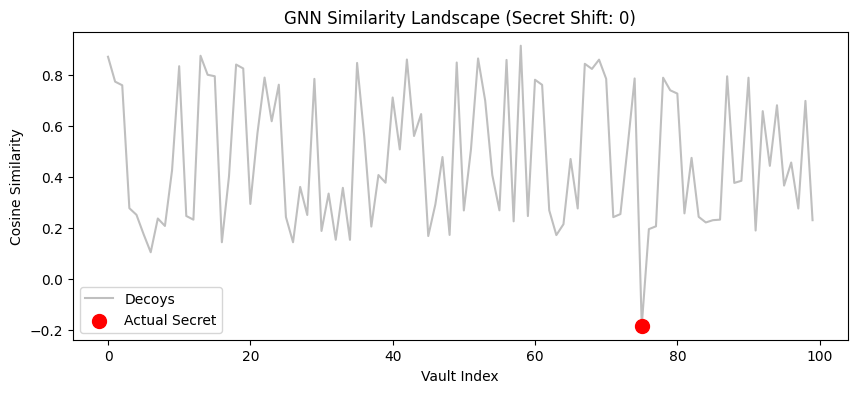

❌ FAILURE: Secret was Rank 100


In [41]:
import matplotlib.pyplot as plt

def execute_detailed_analysis(model, device, secret_shift=0):
    model.eval()
    
    # 1. Anchor Creation
    secret_basis = [(RAAGWord([secret_shift + i]), RAAGWord([secret_shift + i + 100])) for i in range(5)]
    anchor_graph = subgroup_to_graph(secret_basis).to(device)
    with torch.no_grad():
        anchor_emb = model.forward_one(anchor_graph)

    # 2. Vault Creation
    vault = []
    correct_index = random.randint(0, 99)
    print(f"🔒 Secret hidden at Index: {correct_index}")

    for i in range(100):
        if i == correct_index:
            vault.append(apply_nielsen_moves_fixed(secret_basis, num_moves=5))
        else:
            r_shift = random.choice([s for s in range(-400, 400) if abs(s - secret_shift) > 150])
            vault.append([(RAAGWord([r_shift + j]), RAAGWord([r_shift + j + 100])) for j in range(5)])

    # 3. Scanning and Scoring
    similarities = []
    for i, sub in enumerate(vault):
        g = subgroup_to_graph(sub).to(device)
        with torch.no_grad():
            emb = model.forward_one(g)
            sim = F.cosine_similarity(anchor_emb, emb).item()
            similarities.append(sim)

    # --- 4. DATA VISUALIZATION & ANALYSIS ---
    results = np.array(similarities)
    top_indices = np.argsort(results)[-10:][::-1] # Get top 10
    
    print(f"\n{'='*50}")
    print(f"{'RANK':<5} | {'INDEX':<7} | {'SIMILARITY':<12} | {'STATUS'}")
    print(f"{'-'*50}")
    
    for rank, idx in enumerate(top_indices, 1):
        status = "⭐ TARGET" if idx == correct_index else ""
        print(f"{rank:<5} | {idx:<7} | {results[idx]:.4f}       | {status}")
    
    print(f"{'='*50}")

    # Plotting the "Confidence Landscape"
    plt.figure(figsize=(10, 4))
    plt.plot(results, color='gray', alpha=0.5, label='Decoys')
    plt.scatter(correct_index, results[correct_index], color='red', s=100, label='Actual Secret', zorder=5)
    plt.title(f"GNN Similarity Landscape (Secret Shift: {secret_shift})")
    plt.xlabel("Vault Index")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.show()

    if top_indices[0] == correct_index:
        print(f"✅ SUCCESS: Clear separation of {results[correct_index] - np.mean(results):.4f}")
    else:
        print(f"❌ FAILURE: Secret was Rank {list(np.argsort(results)[::-1]).index(correct_index) + 1}")

execute_detailed_analysis(model, device, secret_shift=0)